In [82]:
# Imports
import numpy as np
import numpy.linalg as nplin
import numpy.random as npran
import scipy as sp
import scipy.linalg as splin
import scipy.stats as spstat
import matplotlib.pyplot as plt
import inspect
import requests
from __future__ import division

import glmnet
reload(glmnet)
import knockoffGLM as ko
reload(ko)       # as I update it
import simulate as sim
reload(sim)

# show pyplots in the notebook
%matplotlib inline

In [48]:
# Since I'm parrallel computing, need to make sure I'm using different seeeds to generate random numbers
# these come from random.org, and should be truely random
# the function is a tad spotty due parsing a web page isntead of using the API, so may need to be run a few times
# also, it errors out when the request is rejected due to server load
seeds1 = sim.getRandomIntegers(num=1000,min=1,max=1000000000)
seeds2 = sim.getRandomIntegers(num=1000,min=1,max=1000000000)

Lets see how far off the emperical cross moments are from the desired ones when we have a really easy case - pretty much 0 covariance.

In [83]:
n = 1000
p = 50
X,y = sim.genXy_bern_X_norm_beta(seed=None,n=n,p1=0,x_prob=.25,pnull=p,base_prob=.25,beta_sd=1)
kologit = ko.knockoff_logit(y,X,.2,knockoff='binary',tol=1E-5)
kologit._binary_knockoff()

X_lrg = np.hstack((kologit.X,kologit.X_ko))
Mhat  = np.dot(X_lrg.T,X_lrg)/n
M      = kologit.M
print 'Difference of M and M hat has %.3f of Ms norm' % (nplin.norm(Mhat-M)/nplin.norm(M)) # see how we do in terms of Frobenius norm
print '%d of the variables needed relaxation' % (np.sum(kologit.por>0))

Difference of M and M hat has 0.085 of Ms norm
0 of the variables needed relaxation


In [ ]:
kologit.fit()

In [80]:
np.append([1,2,3],np.inf)

array([  1.,   2.,   3.,  inf])

In [81]:
np.amax([1,2,3,np.inf])

inf

In [51]:
Ws = set(np.abs(kologit.w_value))
min([t for t in Ws if np.sum(kologit.w_value<=-t)/max(1,np.sum(kologit.w_value>=t)) <= kologit.q])

0.07758285479830436

In [52]:
min([t for t in kologit.Ws if np.sum(kologit.w_value<=-t)/max(1,np.sum(kologit.w_value>=t)) <= kologit.q])

0.07758285479830436

In [65]:
len(kologit.ts) - len(kologit.Ws)

0

In [64]:
[t for t in kologit.Ws if np.sum(kologit.w_value<=-t)/max(1,np.sum(kologit.w_value>=t)) <= kologit.q]

[0.071432994356975352, 0.074119233521779113]

Now, what if we generate $X$ with actual covariance using the isling model? We'll generate the A matrix as random normal with low variance.

In [428]:
n = 1000
p = 20
X,y = sim.genXy_binary_X_norm_beta(seed=None,n=n,p1=0,pnull=p,base_prob=.25,beta_sd=1,A_sd=.2)
kologit = ko.knockoff_logit(y,X,knockoff='binary',tol=1E-14,maxiter=1000)
kologit._binary_knockoff()

X_lrg = np.hstack((kologit.X,kologit.X_ko))
Mhat  = np.dot(X_lrg.T,X_lrg)/n
M      = kologit.M
print 'Difference of M and M hat has %.3f of Ms norm' % (nplin.norm(Mhat-M)/nplin.norm(M)) # see how we do in terms of Frobenius norm
print '%d of the variables needed relaxation' % (np.sum(kologit.por>0)) 

Difference of M and M hat has 0.033 of Ms norm
0 of the variables needed relaxation


This does pretty well. However, as we add more and more variables, eventually we run into numerical issues with the Newton-Raphson itterations. The solutions suggested by Schafer is to relax the covariance between the $X_i$ and $X_1,...,X_{i-1}$ until the Hessian is no longer illconditioned. In the extreme, this is always possible by making $X_i$ independent of all the prior variables.

In [429]:
n = 1000
p = 70
X,y = sim.genXy_binary_X_norm_beta(seed=None,n=n,p1=0,pnull=p,base_prob=.25,beta_sd=1,A_sd=.2)
kologit = ko.knockoff_logit(y,X,knockoff='binary',tol=1E-14,maxiter=1000)
kologit._binary_knockoff()

X_lrg = np.hstack((kologit.X,kologit.X_ko))
Mhat  = np.dot(X_lrg.T,X_lrg)/n
M      = kologit.M
print 'Difference of M and M hat has %.3f of Ms norm' % (nplin.norm(Mhat-M)/nplin.norm(M)) # see how we do in terms of Frobenius norm
print '%d of the variables needed relaxation' % (np.sum(kologit.por>0))

Difference of M and M hat has 0.218 of Ms norm
4 of the variables needed relaxation


####How do the binary knockoffs do as compared to the originals?
First case, p=20, all of the variables are null, binaries generated with no covariance

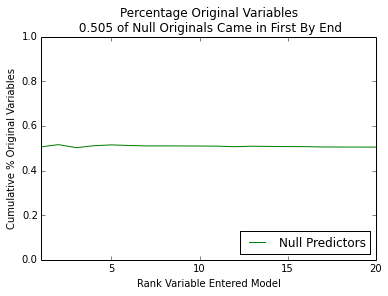

In [430]:
# All null variables, sparse, seeds1
null_sparse = sim.ko_test(procs=4,seeds=seeds1,func=sim.genXy_bern_X_norm_beta,n=1000,p1=0,pnull=20,x_prob=.25,base_prob=.25,beta_sd=1)
null_sparse.plot_ko_rank_rate()

Now, p=20, binaries come from isling model

The cross momement matrix violates necessary conditions for being random Bernoulli


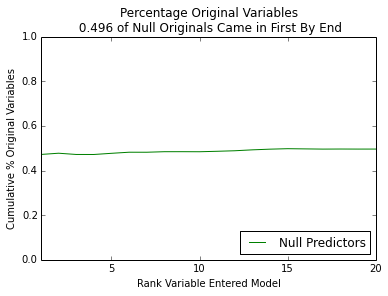

In [442]:
# All null variables, sparse, seeds1
null_sparse = sim.ko_test(procs=4,seeds=seeds1,func=sim.genXy_binary_X_norm_beta,n=1000,p1=0,pnull=20,base_prob=.25,beta_sd=1,A_base_diag=-1,A_sd=.2)
null_sparse.plot_ko_rank_rate()